<a href="https://colab.research.google.com/github/furibeguerra/procesamiento_lenguaje_natural_2025B3/blob/main/Desaf%C3%ADo_3_Uribe_Guerra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Desafio 3

# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [ ]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2025-04-17 02:17:03--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2025-04-17 02:17:03--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0s      

2025-04-17 02:17:03 (95.0 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2025-04-17 02:17:03--
Total wall clock time: 0.5s
Downloaded: 1 files, 23K in 0s (95.0 MB/s)


In [ ]:
from torch_helpers import Tokenizer
from torch_helpers import text_to_word_sequence
from torch_helpers import pad_sequences

train_len = 4

In [ ]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):

    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []



    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            optimizer.zero_grad()

            output = model(train_data.to(device)).cpu()

            loss = criterion(output, train_target)

            epoch_train_loss += loss.item()


            loss.backward()

            optimizer.step()

            accuracy = categorical_acc(output, train_target)

            epoch_train_accuracy += accuracy.item()


        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)


        valid_data, valid_target = next(iter(valid_loader))

        output = model(valid_data.to(device)).cpu()

        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset libros clasicos

In [ ]:
#Aca validare si cargue correctamente los libros:
import os
if os.path.exists('./librostxt'):
    print("La carpeta 'librostxt' existe.")
else:
    print("La carpeta 'librostxt' NO existe. Asegúrate de ejecutar la celda de descarga.")

La carpeta 'librostxt' existe.


In [ ]:
import os
archivos_en_carpeta = os.listdir('./librostxt')
print("Archivos encontrados en 'librostxt':")
for archivo in archivos_en_carpeta:
    print(archivo)

Archivos encontrados en 'librostxt':
Lucio Anneo Seneca - De la Brevedad de la Vida.txt
Friedrich Nietzsche - Asi Hablo Zaratustra.txt
Nicolas Maquiavelo - El Principe.txt
Baltasar Gracian - El Arte de la Prudencia.pdf.txt


In [ ]:
def cargar_libros_clasicos(file_paths, book_names):
    data = []
    for file_path, book_name in zip(file_paths, book_names):
        with open(file_path, 'r', encoding='latin-1') as f:
            lines = f.read().splitlines()
            for line in lines:
                if line.strip():
                    data.append({
                        "texto": line,

                    })

    df = pd.DataFrame(data, columns=["texto"])
    return df

In [ ]:
file_paths = [
        "/content/librostxt/Baltasar Gracian - El Arte de la Prudencia.pdf.txt",
        "/content/librostxt/Friedrich Nietzsche - Asi Hablo Zaratustra.txt",
        "/content/librostxt/Lucio Anneo Seneca - De la Brevedad de la Vida.txt",
        "/content/librostxt/Nicolas Maquiavelo - El Principe.txt"
    ]

book_names = [
    "Baltasar Gracian: El Arte de la Prudencia",
    "Friedrich Nietzsche: Asi Hablo Zaratustra.tx",
    "Lucio Anneo Seneca: De la Brevedad de la Vida",
    "Nicolas Maquiavelo: El Principe"
]

df = cargar_libros_clasicos(file_paths, book_names)

print(df.head())
print(f"\nTotal de líneas combinadas: {len(df)}")

                                   texto
0               1El Arte de la Prudencia
1                      Baltasar GraciÃ¡n
2  textos.infoBiblioteca digital abierta
3                      2Texto nÃºm. 3351
4       TÃ­tulo: El Arte de la Prudencia

Total de líneas combinadas: 16052


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 16052


## 1 - Preprocesamiento de datos

### Vistazo a las primeras filas

In [ ]:
df.iloc[:15,0]

,texto
0,1El Arte de la Prudencia
1,Baltasar GraciÃ¡n
2,textos.infoBiblioteca digital abierta
3,2Texto nÃºm. 3351
4,TÃ­tulo: El Arte de la Prudencia
5,Autor: Baltasar GraciÃ¡n
6,"Etiquetas : FilosofÃ­a, tratado"
7,Editor: Edu Robsy
8,Fecha de creaciÃ³n : 5 de marzo de 2018
9,Fecha de modificaciÃ³n : 23 de julio de 2019


### Concatenamos todos los rows en un solo valor

In [ ]:
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]

<ipython-input-15-9eca7dd73672>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]


### Transformar el corpus a tokens

In [ ]:
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['1el',
 'arte',
 'de',
 'la',
 'prudencia',
 'baltasar',
 'graciã¡n',
 'textos',
 'infobiblioteca',
 'digital',
 'abierta',
 '2texto',
 'nãºm',
 '3351',
 'tã\xadtulo',
 'el',
 'arte',
 'de',
 'la',
 'prudencia']

In [ ]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 168865


In [ ]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
text_sequences[:20]

[['1el', 'arte', 'de', 'la'],
 ['arte', 'de', 'la', 'prudencia'],
 ['de', 'la', 'prudencia', 'baltasar'],
 ['la', 'prudencia', 'baltasar', 'graciã¡n'],
 ['prudencia', 'baltasar', 'graciã¡n', 'textos'],
 ['baltasar', 'graciã¡n', 'textos', 'infobiblioteca'],
 ['graciã¡n', 'textos', 'infobiblioteca', 'digital'],
 ['textos', 'infobiblioteca', 'digital', 'abierta'],
 ['infobiblioteca', 'digital', 'abierta', '2texto'],
 ['digital', 'abierta', '2texto', 'nãºm'],
 ['abierta', '2texto', 'nãºm', '3351'],
 ['2texto', 'nãºm', '3351', 'tã\xadtulo'],
 ['nãºm', '3351', 'tã\xadtulo', 'el'],
 ['3351', 'tã\xadtulo', 'el', 'arte'],
 ['tã\xadtulo', 'el', 'arte', 'de'],
 ['el', 'arte', 'de', 'la'],
 ['arte', 'de', 'la', 'prudencia'],
 ['de', 'la', 'prudencia', 'autor'],
 ['la', 'prudencia', 'autor', 'baltasar'],
 ['prudencia', 'autor', 'baltasar', 'graciã¡n']]

### Proceso de tokenizacion

In [ ]:
tok = Tokenizer()
tok.fit_on_texts(text_sequences)
sequences = tok.texts_to_sequences(text_sequences)
sequences[:20]

[[8348, 241, 1, 4],
 [241, 1, 4, 457],
 [1, 4, 457, 4083],
 [4, 457, 4083, 1651],
 [457, 4083, 1651, 916],
 [4083, 1651, 916, 3263],
 [1651, 916, 3263, 3264],
 [916, 3263, 3264, 2053],
 [3263, 3264, 2053, 5402],
 [3264, 2053, 5402, 3265],
 [2053, 5402, 3265, 8349],
 [5402, 3265, 8349, 1282],
 [3265, 8349, 1282, 5],
 [8349, 1282, 5, 241],
 [1282, 5, 241, 1],
 [5, 241, 1, 4],
 [241, 1, 4, 457],
 [1, 4, 457, 1503],
 [4, 457, 1503, 4083],
 [457, 1503, 4083, 1651]]

In [ ]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 168861


## 2 - Input y target

In [ ]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1]

print(x_data.shape)
print(y_data_int.shape)

(168861, 3)
(168861,)


In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'y',
 3: 'que',
 4: 'la',
 5: 'el',
 6: 'a',
 7: 'en',
 8: 'los',
 9: 'se',
 10: 'no',
 11: 'es',
 12: 'con',
 13: 'su',
 14: 'lo',
 15: 'un',
 16: 'mã¡s',
 17: 'por',
 18: 'las',
 19: 'para',
 20: 'del',
 21: 'al',
 22: 'una',
 23: 'yo',
 24: 'como',
 25: 'mi',
 26: 'sus',
 27: 'todo',
 28: 'me',
 29: 'pero',
 30: 'ha',
 31: 'ser',
 32: 'zaratustra',
 33: 'si',
 34: 'le',
 35: 'asã\xad',
 36: 'todos',
 37: 'tambiã©n',
 38: 'o',
 39: 'sã\xad',
 40: 'tiempo',
 41: 'son',
 42: 'ni',
 43: 'mismo',
 44: 'â»',
 45: 'pues',
 46: 'sin',
 47: 'cuando',
 48: 'ã©l',
 49: 'ya',
 50: 'siempre',
 51: 'tu',
 52: 'mã\xad',
 53: 'cosas',
 54: 'hombre',
 55: 'ellos',
 56: 'vosotros',
 57: 'verdad',
 58: 'hombres',
 59: 'porque',
 60: 'bien',
 61: 'quien',
 62: 'vez',
 63: 'te',
 64: 'tãº',
 65: 'esto',
 66: 'este',
 67: 'tan',
 68: 'he',
 69: 'sobre',
 70: 'tiene',
 71: 'todas',
 72: 'otro',
 73: 'mas',
 74: 'hay',
 75: 'otros',
 76: 'ahora',
 77: 'vida',
 78: 'gran',
 79: 'entre',
 80: '

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

19955

In [ ]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [ ]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [ ]:
assert (y_data_int > 0).all()


Aclaracion:

No realice one-hot encoding porque CrossEntropyLoss no lo necesita. Esta función espera que las etiquetas sean índices enteros de clase, no vectores. Si hiciéramos one-hot, estaríamos pasando un formato incorrecto y el loss no funcionaría como corresponde.

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
class Data(Dataset):
    def __init__(self, x, y):

        self.x = torch.from_numpy(x.astype(np.int32))

        self.y = torch.from_numpy(y.astype(np.int64))


        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(x_data, y_data_int_offset)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = vocab_size

print("Output dim", output_dim)

input_size: 3
Output dim 19955


In [ ]:
torch.manual_seed(12)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 135089
Tamaño del conjunto de validacion: 33772


## 3 - Entrenar el modelo

In [ ]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()

        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=5, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.5)
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, prev_state=None):
        if prev_state is None:
            batch_size = x.shape[0]
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:]))

        out = self.fc2(out)

        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device))

In [ ]:
model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)
if cuda: model1.cuda()

model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)

model1_criterion = torch.nn.CrossEntropyLoss()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)


### Summary

In [ ]:
input_tensor = data_set[0][0].unsqueeze(0).to(device)

# Mostrar resumen del modelo
summary(model1, input_data=input_tensor)

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 19955]                --
├─Embedding: 1-1                         [1, 3, 5]                 99,780
├─LSTM: 1-2                              [1, 3, 64]                51,456
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 19955]                658,515
Total params: 811,831
Trainable params: 811,831
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.91
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 3.25
Estimated Total Size (MB): 3.41

In [ ]:
def categorical_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=1, keepdim=True)[1]
    y_test_tag = y_test.view(-1, 1)
    correct_results_sum = (y_pred_tag == y_test_tag).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    return acc


In [ ]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=100
                )

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1/100 - Train loss 7.095 - Train accuracy 0.045 - Valid Loss 7.150 - Valid accuracy 0.063
Epoch: 2/100 - Train loss 6.796 - Train accuracy 0.058 - Valid Loss 7.051 - Valid accuracy 0.056
Epoch: 3/100 - Train loss 6.663 - Train accuracy 0.065 - Valid Loss 7.038 - Valid accuracy 0.076
Epoch: 4/100 - Train loss 6.559 - Train accuracy 0.073 - Valid Loss 6.981 - Valid accuracy 0.079
Epoch: 5/100 - Train loss 6.428 - Train accuracy 0.083 - Valid Loss 6.913 - Valid accuracy 0.080
Epoch: 6/100 - Train loss 6.330 - Train accuracy 0.091 - Valid Loss 6.896 - Valid accuracy 0.081
Epoch: 7/100 - Train loss 6.255 - Train accuracy 0.097 - Valid Loss 6.856 - Valid accuracy 0.085
Epoch: 8/100 - Train loss 6.196 - Train accuracy 0.102 - Valid Loss 6.878 - Valid accuracy 0.082
Epoch: 9/100 - Train loss 6.146 - Train accuracy 0.105 - Valid Loss 6.870 - Valid accuracy 0.086
Epoch: 10/100 - Train loss 6.109 - Train accuracy 0.108 - Valid Loss 6.844 - Valid accuracy 0.084
Epoch: 11/100 - Train loss 6.

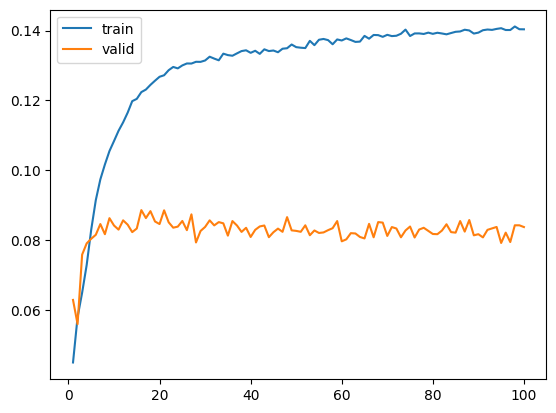

In [ ]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

In [ ]:
torch.save(model1.state_dict(), "model1_weights.pth")


## Cargar modelo

In [ ]:
model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)
model1.load_state_dict(torch.load("model1_weights.pth"))
model1.to(device)
model1.eval()


Model1(
  (embedding): Embedding(19956, 5, padding_idx=0)
  (lstm1): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=19955, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

## 4 - Predicción de próxima palabra

In [ ]:
def predict_next_word(model, tokenizer, input_text, max_len=3):
    """
    Predice la próxima palabra dada una frase de entrada.

    Args:
        model (torch.nn.Module): Modelo entrenado.
        tokenizer (Tokenizer): Tokenizador ya ajustado.
        input_text (str): Frase inicial.
        max_len (int): Longitud máxima de entrada (usada en pad_sequences).

    Returns:
        str: Frase con la palabra predicha añadida.
    """
    model.eval()

    # Tokenizar y preprocesar
    encoded = tokenizer.texts_to_sequences([input_text])[0]
    padded = pad_sequences([encoded], maxlen=max_len, padding='pre')
    tensor = torch.from_numpy(padded.astype(np.int32)).to(device)

    # Predecir
    with torch.no_grad():
        output = model(tensor)
        predicted_idx = output.argmax(dim=-1).item()

    predicted_word = None
    for word, index in tokenizer.word_index.items():
        if index == predicted_idx + 1:
            predicted_word = word
            break

    predicted_word = predicted_word if predicted_word is not None else "<UNK>"

    return input_text + " " + predicted_word


In [ ]:
input_text = "vida y el "
output = predict_next_word(model1, tok, input_text)
print(output)


vida y el  asno


In [ ]:
input_text = "brevedad de la "
output = predict_next_word(model1, tok, input_text)
print(output)

brevedad de la  vida


In [ ]:
input_text = "sabio para el "
output = predict_next_word(model1, tok, input_text)
print(output)

sabio para el  que


In [ ]:
input_text = "la verdadera soberanía consiste en la "
output = predict_next_word(model1, tok, input_text)
print(output)

la verdadera soberanía consiste en la  vida


Parece que la unica palabra que predice es "Vida" y pronombres relativos por lo que no esta resultando ser un modeo fiable.

## 5 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32)).to(device)
        # Predicción softmax
        y_hat = model1(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='la verdadera soberanía consiste en'

generate_seq(model1, tok, input_text, max_length=3, n_words=2)

'la verdadera soberanía consiste en la ahora'

## 6 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.